### Problem Statment: Use regression analysis to predict vehicle performance (mileage travelled per Gallen) Using Stochostic Gradient Descent(SGD)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
df=pd.read_csv(r"C:\Users\gaikw\Downloads\auto-mpg.csv")

### EDA & Data Cleaning

In [3]:
df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite


In [4]:
df.shape

(398, 9)

In [5]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [6]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [7]:
df['horsepower'].sample(10)

318     90
108     88
368     88
46      72
389    112
125     95
139    140
203     71
178     88
246     52
Name: horsepower, dtype: object

#### There are '?' values in the 'horsepower' column. Let's explore these  in more detail.


In [8]:
print(f"Total '?' values in horsepower: {(df['horsepower'] == '?').sum()}")

Total '?' values in horsepower: 6


In [9]:
df['horsepower'] = df['horsepower'].replace("?", np.nan)
df['horsepower'].isnull().sum()

6

In [10]:
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

#### Filling null values with mean value of horsepower

In [11]:
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())
df['horsepower'].isnull().sum()

0

In [12]:
df.columns,df.shape

(Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
        'acceleration', 'model year', 'origin', 'car name'],
       dtype='object'),
 (398, 9))

### Checking for Outliers

In [13]:
from scipy import stats
numeric_df = df.select_dtypes(include=[np.number])

# Compute Z-scores
z_scores = np.abs(stats.zscore(numeric_df))

# Count outliers
num_outliers = (z_scores > 3).any(axis=1).sum()

print(f"Total outlier rows (Z-score > 3): {num_outliers}")


Total outlier rows (Z-score > 3): 7


#### Removing all rows from your dataset that contain extreme values (outliers) in any numeric column, where Z-score > 3.

In [14]:
df = df[(z_scores < 3).all(axis=1)]
df.shape

(391, 9)

### Plotting Histogram

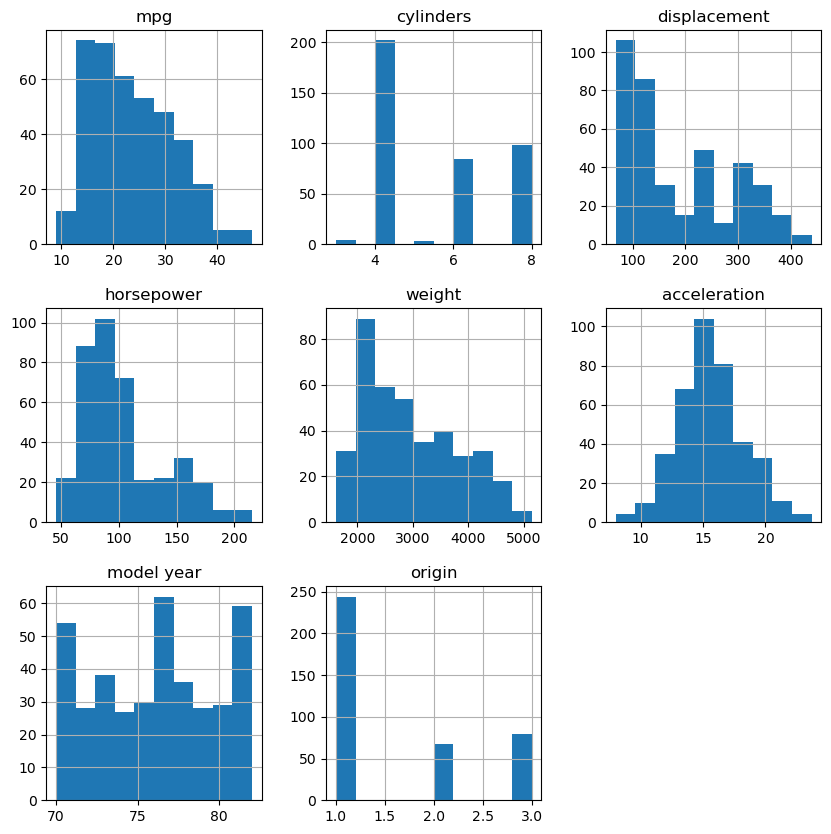

In [15]:
df.hist(figsize=(10, 10))
None

### Checking correlation coefficients of mpg to df

mpg             1.000000
model year      0.567035
origin          0.560931
acceleration    0.392418
cylinders      -0.772335
horsepower     -0.780183
displacement   -0.806097
weight         -0.833008
Name: mpg, dtype: float64


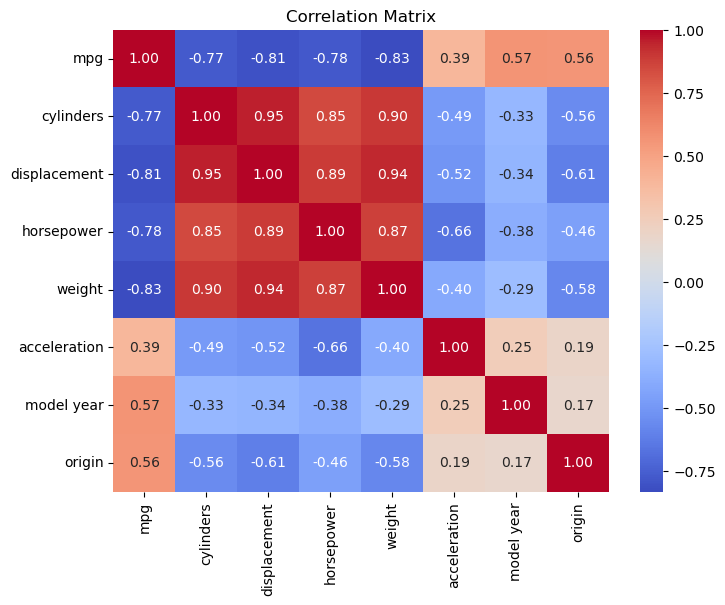

In [16]:
num_df = df.select_dtypes(include=[np.number])
print(num_df.corr()['mpg'].sort_values(ascending=False))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


##### Too Good to Be True lets try SGD if overfits we will perform VIF 

In [17]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,23.574425,5.429668,190.604859,103.147868,2956.048593,15.593862,76.048593,1.578005
std,7.738897,1.688434,101.087297,35.879049,838.487310,2.625919,3.671120,0.806020
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,102.500000,76.000000,2221.500000,14.000000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,95.000000,2790.000000,15.500000,76.000000,1.000000
75%,29.000000,7.000000,260.000000,120.000000,3572.000000,17.150000,79.000000,2.000000
max,46.600000,8.000000,440.000000,215.000000,5140.000000,23.700000,82.000000,3.000000


In [18]:
df.nlargest(5, 'mpg')


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
322,46.6,4,86.0,65.0,2110,17.9,80,3,mazda glc
329,44.6,4,91.0,67.0,1850,13.8,80,3,honda civic 1500 gl
325,44.3,4,90.0,48.0,2085,21.7,80,2,vw rabbit c (diesel)
326,43.4,4,90.0,48.0,2335,23.7,80,2,vw dasher (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,2,volkswagen rabbit custom diesel


In [19]:
df.nsmallest(5, 'mpg')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
28,9.0,8,304.0,193.0,4732,18.5,70,1,hi 1200d
25,10.0,8,360.0,215.0,4615,14.0,70,1,ford f250
26,10.0,8,307.0,200.0,4376,15.0,70,1,chevy c20
27,11.0,8,318.0,210.0,4382,13.5,70,1,dodge d200
67,11.0,8,429.0,208.0,4633,11.0,72,1,mercury marquis


# Visualization 

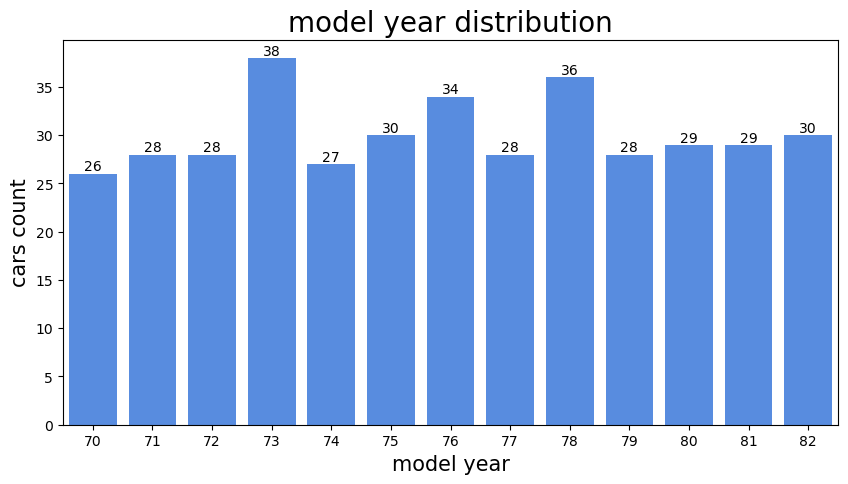

In [20]:
# displaying histgram of model year column
plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'model year', data = df, color = '#4287f5')
ax.bar_label(ax.containers[0], label_type='edge')
plt.title("model year distribution", fontsize = 20)
plt.xlabel("model year", fontsize = 15)
plt.ylabel("cars count", fontsize = 15)
plt.show()

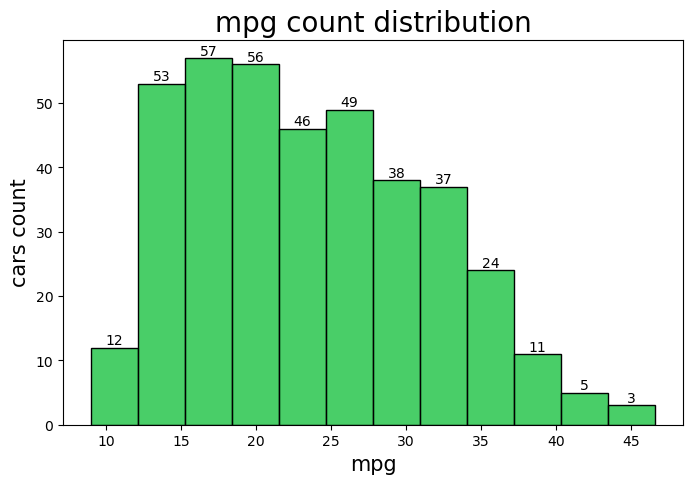

In [21]:
# ploting mpg distribution
plt.figure(figsize=(8,5))
ax = sns.histplot(x = 'mpg', data = df, color = "#0cbe35")
ax.bar_label(ax.containers[0], label_type='edge')
plt.title("mpg count distribution", fontsize = 20)
plt.xlabel("mpg", fontsize = 15)
plt.ylabel("cars count", fontsize = 15)
plt.show()

Most of the cars in our dataset have mpg between 15 to 30. Our data is also skewed to the right.

let's compare these findings to cylinders and horsepower columns

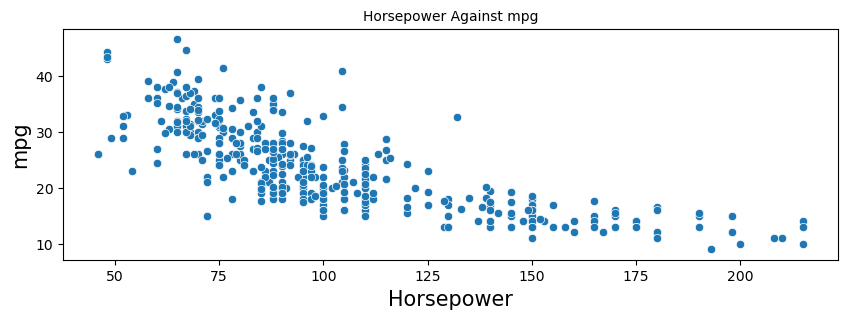

In [22]:
# ploting mpg against horsepower
plt.figure(figsize=(10,3))
sns.scatterplot(x = 'horsepower', y = 'mpg', data = df)
plt.title("Horsepower Against mpg", fontsize = 10)
plt.xlabel("Horsepower", fontsize = 15)
plt.ylabel("mpg", fontsize = 15)
plt.show()

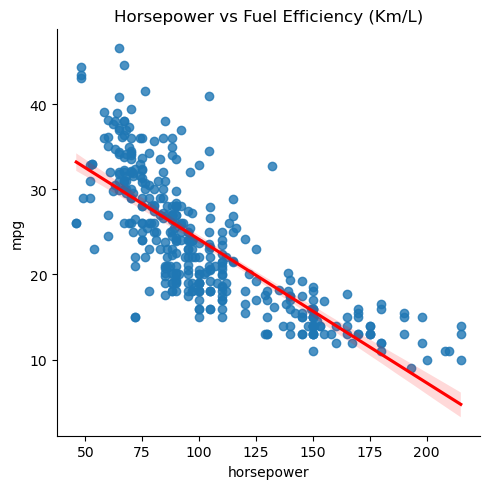

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(data=df, x='horsepower', y='mpg', line_kws={'color': 'red'}, ci=95)
plt.title("Horsepower vs Fuel Efficiency (Km/L)")
plt.tight_layout()
plt.show()


Standard Expectation: Higher horsepower (generally) means lower fuel efficiency (fewer miles per gallon, or fewer kilometers per liter).

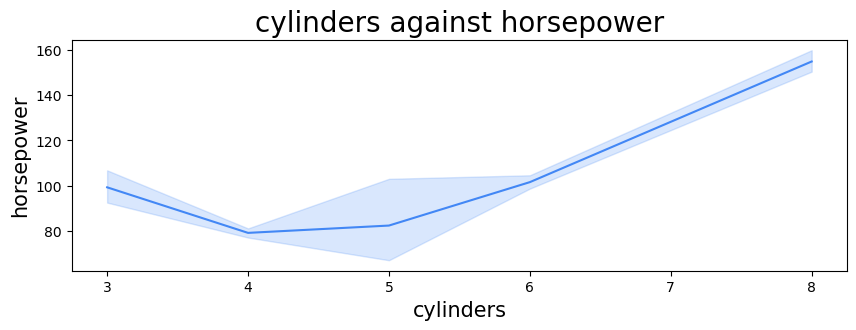

In [24]:
# ploting cylinders anainst horsepower
plt.figure(figsize=(10,3))
sns.lineplot(x = 'cylinders', y = 'horsepower', data = df, color = '#4287f5')
plt.title("cylinders against horsepower", fontsize = 20)
plt.xlabel("cylinders", fontsize = 15)
plt.ylabel("horsepower", fontsize = 15)
plt.show()


As the number of cylinders increases, the horsepower also increases—showing a positive correlation.

The jump from 5 to 8 cylinders shows the largest increase in horsepower, along with wider confidence intervals, indicating more variability in that group.

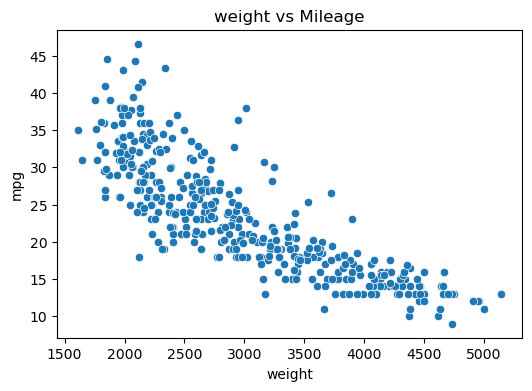

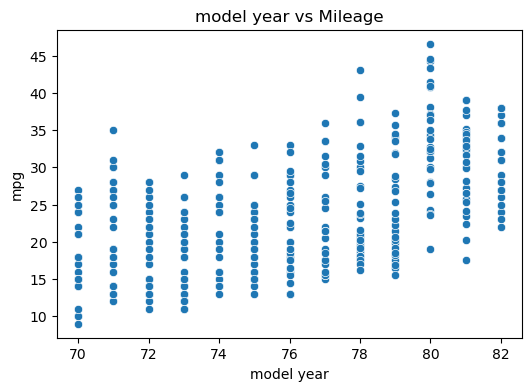

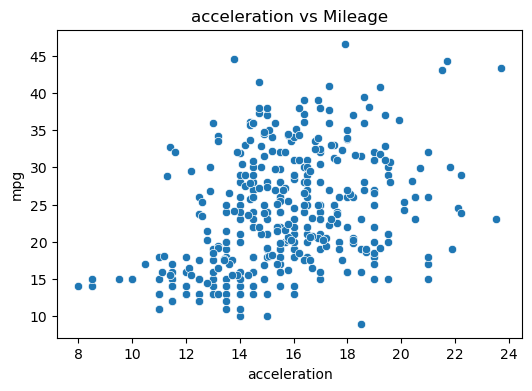

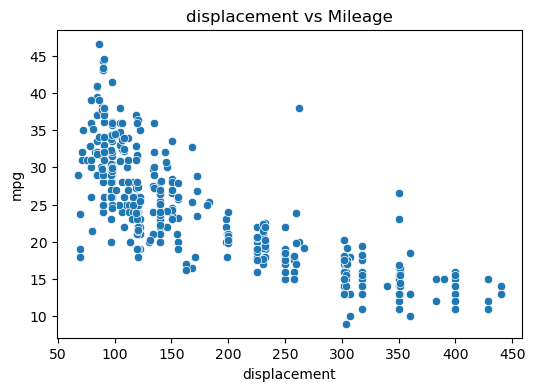

In [25]:
features = ['weight', 'model year', 'acceleration', 'displacement']
for col in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['mpg'])
    plt.title(f"{col} vs Mileage")
    plt.show()


#### As weight increases, the spread of mpg values appears to narrow somewhat, and the mpg values consistently remain lower.

# Model Building

### Importing librarys for SGD ,train_test_split and StandardScaler

In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define features (X) and target variable (y)


In [27]:
X = df.drop(columns=['mpg', 'car name'])  # we are excluding target & categorical col car name
y = df['mpg']

### Split data into training & test sets


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### StandardScaler


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initialize and train model


In [30]:
model = SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01, random_state=42)

model.fit(X_train_scaled, y_train)

SGDRegressor(random_state=42)

### Evaluate model


In [31]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 10.475774678348522
R² Score: 0.82


### SGD R² Score: 0.82 lets try to improve it using GridSearchCV
---

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'elasticnet'],
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-4]
}

SGD_grid_search = GridSearchCV(SGDRegressor(random_state=42), param_grid, cv=5)
SGD_grid_search.fit(X_train_scaled, y_train)

Grid_best_model = SGD_grid_search.best_estimator_
Grid_best_model

SGDRegressor(alpha=0.001, random_state=42)

In [33]:
y_pred = SGD_grid_search.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R² Score: {r2:.3f}")

# Compare train vs test
print("Train R²:", SGD_grid_search.score(X_train_scaled, y_train))
print("Test R²:", SGD_grid_search.score(X_test_scaled, y_test))


MSE: 10.48, R² Score: 0.822
Train R²: 0.8158784563660457
Test R²: 0.8223607173767896


In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(SGD_grid_search, X_train_scaled, y_train, cv=5, scoring='r2')
print("Cross-Validation R²:", scores)
print("Mean R²:", scores.mean())


Cross-Validation R²: [0.82322246 0.83724513 0.79616021 0.75159564 0.8005309 ]
Mean R²: 0.8017508681333384


---
## SGD + GridSearchCV R² Score: 0.82 
## with Mean R²: 0.8017508681333384
---
### lets try to improve it 

In [35]:
import pickle

Grid_best_model = SGD_grid_search.best_estimator_

with open('Car_mileage_pred_model_SGD.pkl', 'wb') as f:
    pickle.dump(Grid_best_model, f)


# Saveing the scaler to a file (important for prediction)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

    
import os
print(os.getcwd())

e:\DATA ANALYSIS\ML\Linear Regression Project\Car_milage_prediction_sgd



 ### we can perform Variance Inflation Factor (VIF), which will help identify multicollinearity 

# VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df.drop(columns=['mpg', 'car name'])
X_num = X.select_dtypes(include=[np.number])
X_const = add_constant(X_num)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i + 1) for i in range(X_num.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))


#### Features like weight, displacement and cylinders  are too linearly dependent on each other we have to drop them 
#### Reason = There should be No Multicollinearity (Independent variables are not too highly correlated with each other.)

In [ ]:
# df_reduced = df.drop(columns=['displacement', 'weight', 'car name'])#, 'cylinders'

In [ ]:
# X_num = df_reduced.drop(columns=['mpg', 'car name'], errors='ignore')
# X_const = add_constant(X_num)

# vif_data = pd.DataFrame()
# vif_data['Feature'] = X_num.columns
# vif_data['VIF'] = [variance_inflation_factor(X_const.values, i + 1) for i in range(X_num.shape[1])]
# print(vif_data)


### Define X (Features) and y (Target)

In [ ]:
# X = df[['cylinders','horsepower','acceleration','origin','model year']]
# y = df['mpg']

### Train Test split 

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


### Lets perform GridSearchCV with SGDRegressor 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'elasticnet'],
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-4]
}

grid_search = GridSearchCV(SGDRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

Grid_best_model = grid_search.best_estimator_

## Evaluate GridSearch + SGD Model

In [ ]:
y_pred = Grid_best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R² Score: {r2:.3f}")

# Compare train vs test
print("Train R²:", Grid_best_model.score(X_train_scaled, y_train))
print("Test R²:", Grid_best_model.score(X_test_scaled, y_test))


# VIF + GridSearch + SGD Model R2 = 0.77

#### Plot residuals 


In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(5, 4))
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Mileage")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


## Lets try Using PolynomialFeatures

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_model = SGDRegressor(max_iter=2000, alpha=0.001)
poly_model.fit(X_train_poly, y_train)



In [ ]:
y_pred_poly = poly_model.predict(X_test_poly)

#### Plot residuals again


In [ ]:
residuals_poly = y_test - y_pred_poly
plt.figure(figsize=(5, 4))
plt.scatter(y_test, residuals_poly)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Polynomial Features)")
plt.xlabel("Actual Mileage")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [ ]:
X_test_poly = poly.transform(X_test_scaled)

In [ ]:
print(X_train_scaled.shape, X_test_scaled.shape)

In [ ]:
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)  # Apply same transformation

In [ ]:
print(X_train_poly.shape, X_test_poly.shape)

## Evaluate Polynomial Model

In [ ]:
y_pred = poly_model.predict(X_test_poly)

# Evaluate Performance
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"New Accuracy after Polynomial: {r2:.2f}")

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(poly_model, X_train_scaled, y_train, cv=5, scoring='r2')
print("Cross-Validation R²:", scores)
print("Mean R²:", scores.mean())


## Polynomial Mean R²: 0.7624592423227349

---


## Here are the all the scores that we have built in this project

- SIMPLE SGD = 0.82
- SGD + GridSearch = 0.82
- r2 Mean R²: 0.7627200037764107

- VIF + GridSearch + SGD Model R2 = 0.77

- Polynomial: 0.82
- Polynomial Mean R²: 0.76

---

##  Lets go with SGD + GridSearch

SGD + GridSearch
It gives the best balance of:
- High performance (same R² as the best)
- Systematic parameter tuning for reliability
- No added complexity like VIF or polynomial features, which can sometimes overfit or complicate deployment


---

### Lets Save the model and  scaler using pickle (important for prediction)


In [ ]:
# import pickle

# Grid_best_model = SGD_grid_search.best_estimator_

# with open('Car_mileage_pred_model_SGD.pkl', 'wb') as f:
#     pickle.dump(Grid_best_model, f)


# # Saveing the scaler to a file (important for prediction)
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

    
# import os
# print(os.getcwd())

### Author : Gaikwad Om |  [LinkedIn Profile](https://www.linkedin.com/in/om-gaikwad-a70421310/)
